# Preface

In this notebook, we consider a sequence prediction problem. Our goal is to illustrate a different setting from the IMDB sentiment analysis problem, where the prediction output is no longer just 1 label.

Goals:
1. `return_sequences` keyword
2. exploit properties in task to use right scaling/activation functions

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tqdm
sns.set(font_scale=1.5, style='darkgrid')

In [3]:
tf.config.set_visible_devices([], 'GPU') # Disable GPU (runtime slow)

# Covid 19 Dataset

Information: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

In [2]:
import kaggle
kaggle.api.authenticate()

In [3]:
kaggle.api.dataset_download_files(
    'sudalairajkumar/novel-corona-virus-2019-dataset',
    path='./data/covid19',
    quiet=False,
    unzip=True,
    force=False,
)

100%|██████████████████████████████████████| 8.52M/8.52M [00:02<00:00, 3.55MB/s]


# Some Minimal Data Exploration

Let us read in the CSV files and look at its contents

In [4]:
data_confirmed = pd.read_csv('data/covid19/time_series_covid_19_confirmed.csv')
data_deaths = pd.read_csv('data/covid19/time_series_covid_19_deaths.csv')

In [5]:
data_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180


In [6]:
data_deaths.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,2772,2782,2792,2802,2812,2836,2855,2869,2881,2899
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,2440,2441,2442,2444,2445,2447,2447,2447,2448,2449
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,3401,3405,3411,3418,3426,3433,3440,3448,3455,3460
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,127,127,127,127,127,127,127,127,127,127
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,704,709,715,725,731,735,742,745,749,757


We extract some numpy arrays of the counts, and country names for labelling

In [7]:
number_confirmed = np.asarray(data_confirmed)[:, 4:].astype('float64')
number_deaths = np.asarray(data_deaths)[:, 4:].astype('float64')
countries = np.asarray(data_confirmed['Country/Region'])
provinces = np.asarray(data_confirmed['Province/State'].fillna(''))
names = [f'{c} {p}' for c, p in zip(countries, provinces)]

The numbers are rather large, so we take a logarithm scaling to control the magnitude. Why is 1.0 added?

In [8]:
number_confirmed = np.log(1.0 + number_confirmed)
number_deaths = np.log(1.0 + number_deaths)

Here, we can plot the numbers and see some rough trends

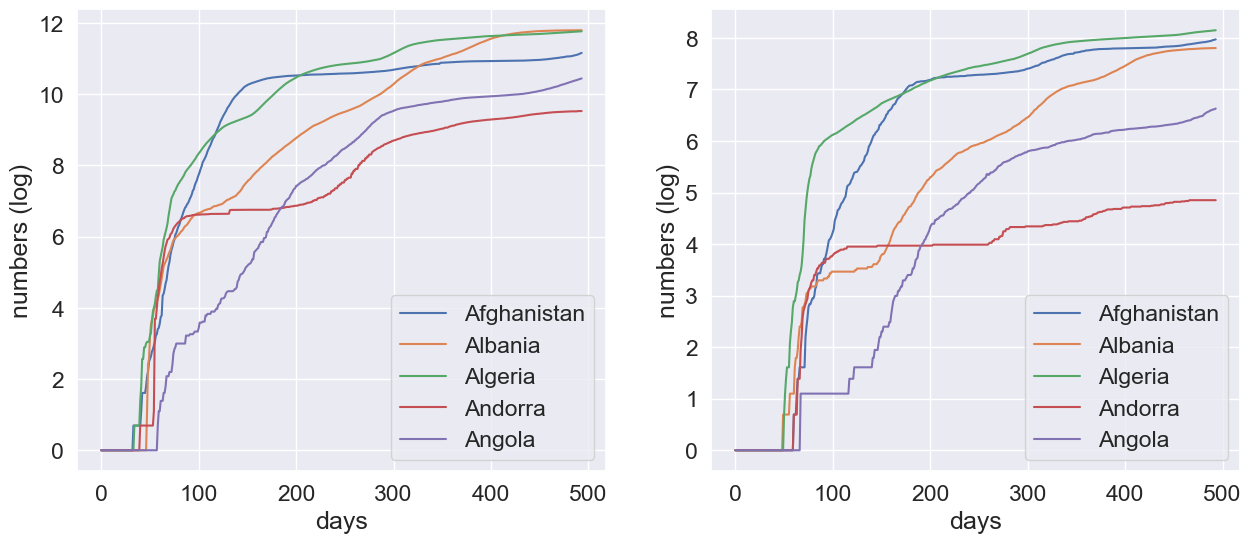

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
for i in range(5):
    ax[0].plot(number_confirmed[i], label=countries[i])
    ax[1].plot(number_deaths[i], label=countries[i])
for a in ax:
    a.legend()
    a.set_xlabel('days')
    a.set_ylabel('numbers (log)')

# LSTM Model

Here, we will build a model that links the confirmed cases to the number of deaths.

We know that there is a link, but there is also a time lag - we cannot just use the same day's confirmed cases to predict that days number of deaths.

However, we should expect a link if we look at all the cumulative confirmed counts. 

We will now keep 20% of the countries data as test set

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test, names_train, names_test = train_test_split(
    number_confirmed[:, :, None], number_deaths[:, :, None], names,
    test_size=0.2, random_state=123)

Now, we build a simple LSTM model for this, using the canned layers from `keras`

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback

In [18]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=[None, x_train.shape[-1]]))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer=Adam(1e-4))

In [19]:
model_save_dir = pathlib.Path('covid_lstm.h5')

if model_save_dir.exists():
    model.load_weights(str(model_save_dir))
else:
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        validation_data=(x_test, y_test),
        epochs=100,
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)]
    )
    model.save_weights(str(model_save_dir))
    results = pd.DataFrame(history.history)
    results['epoch'] = history.epoch

Finally, let us look at the predictions on the test countries/provinces

In [16]:
y_pred = np.squeeze(model.predict(x_test))

2023-02-14 15:01:45.062505: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-14 15:01:45.203261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:01:45.240034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 724ms/step


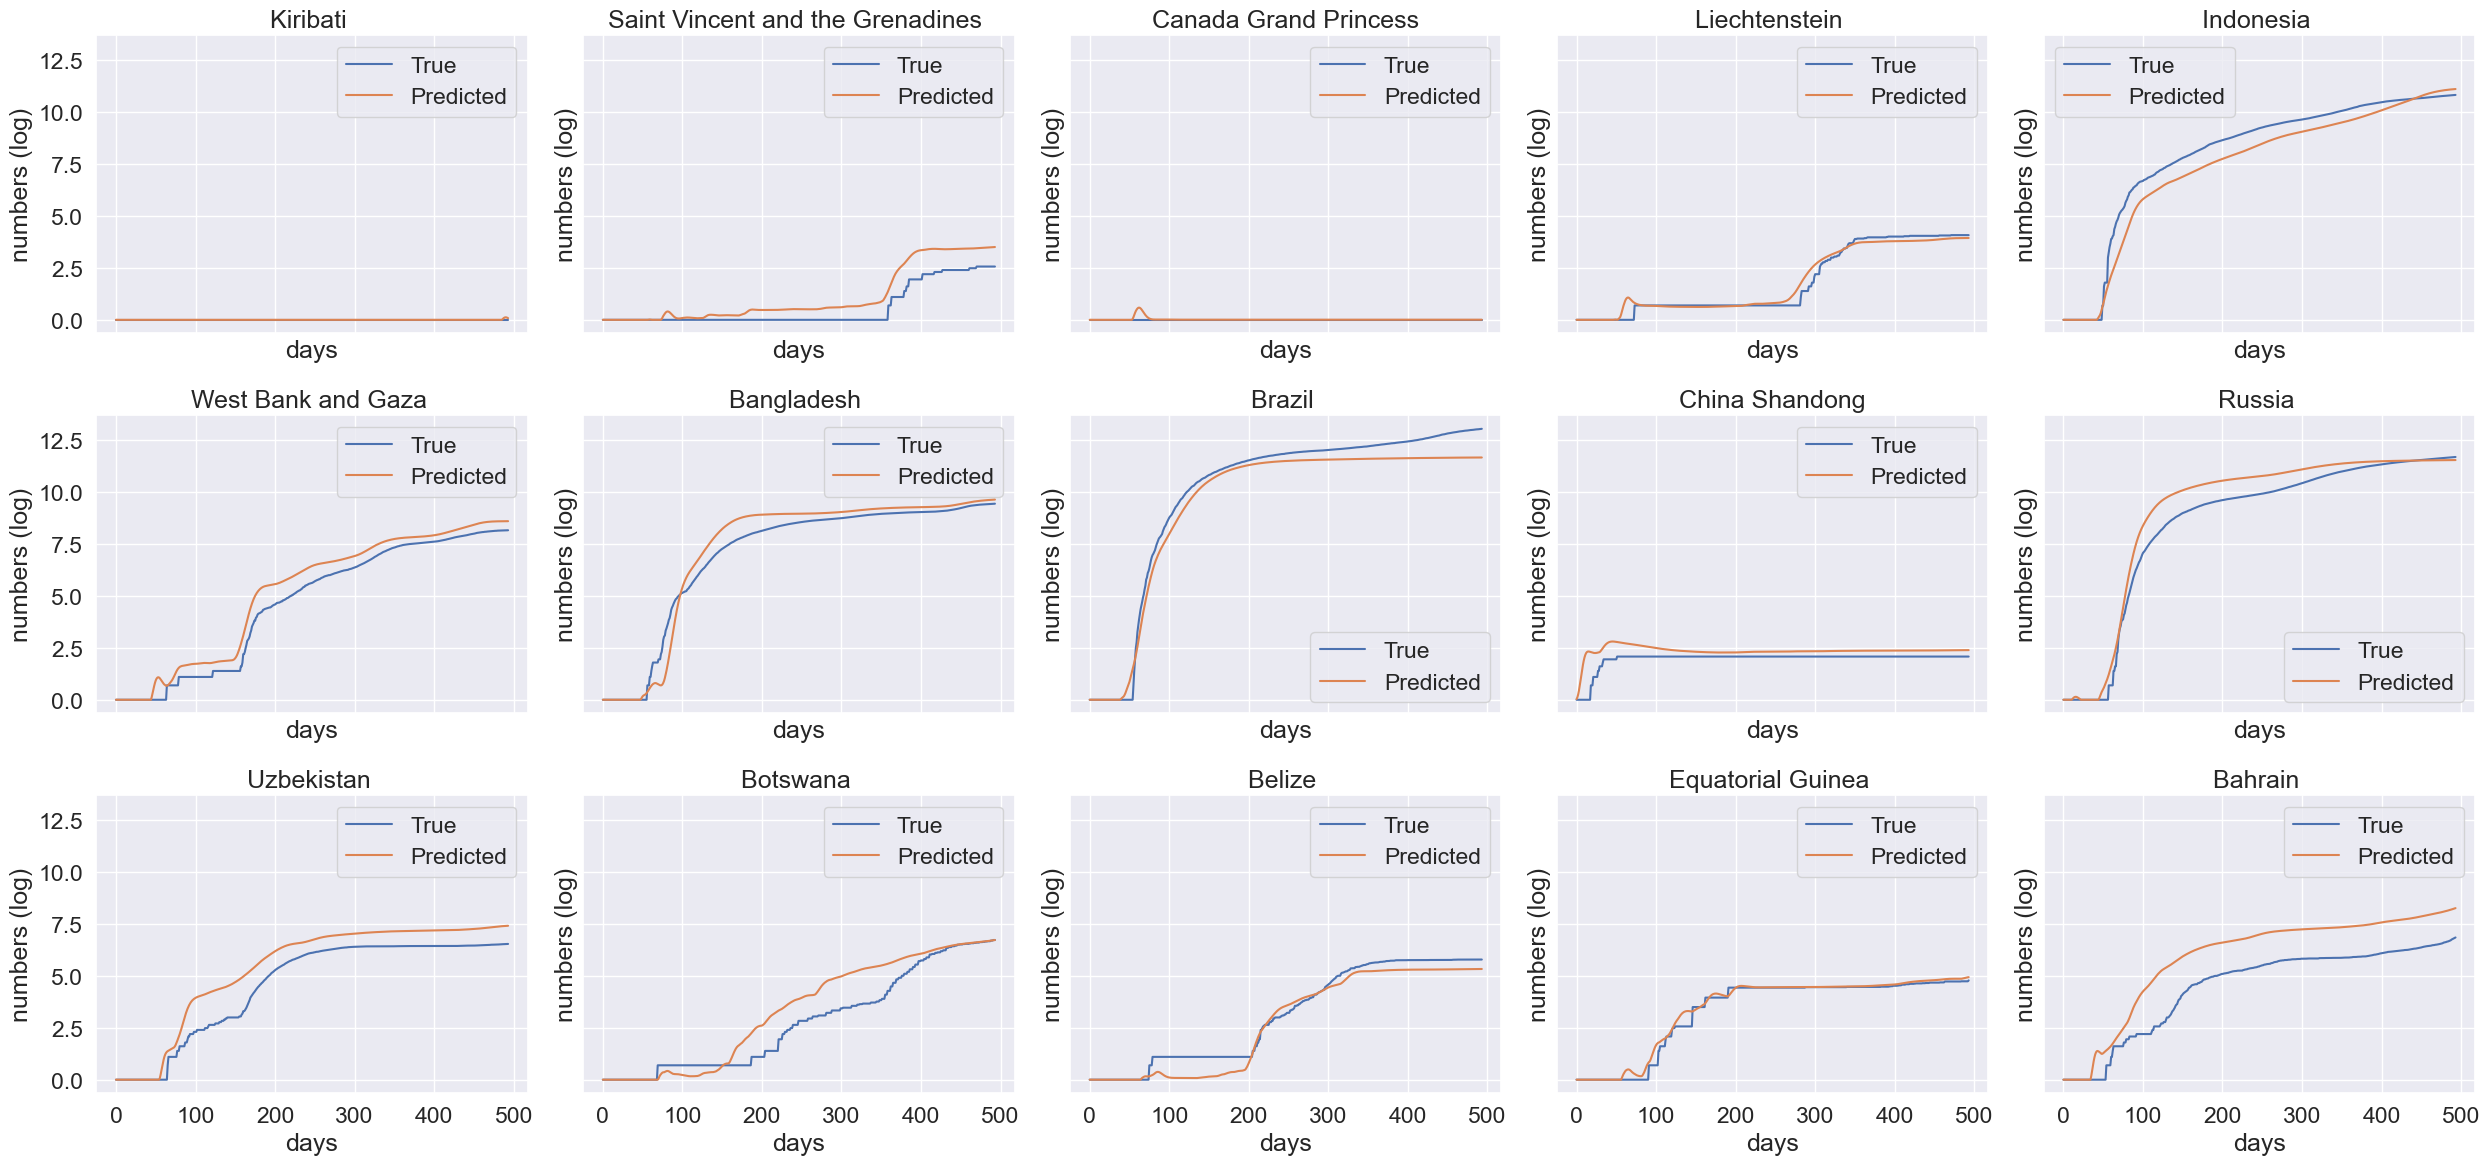

In [17]:
n_rows = 3
n_cols = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), sharex=True, sharey=True)

for i in range(n_rows):
    for j in range(n_cols):
        count = i * n_cols + j
        ax[i,j].plot(y_test[count], label='True')
        ax[i,j].plot(y_pred[count], label='Predicted')
        
        ax[i,j].legend()
        ax[i,j].set_title(names_test[count])
        ax[i,j].set_xlabel('days')
        ax[i,j].set_ylabel('numbers (log)')

fig.tight_layout()

# Exercise

1. Try to modify the target to be a 10-day advance prediction, i.e. the task is to predict the number of deaths 10 days from the current, given the current knowledge of confirmed cases.
2. Try without log scaling, or without ReLU activation. These are called ablation studies
3. Try improving the model in other ways (we will learn some techniques in the following classes)